# Молочный отбор: прогнозирование удоя и вкуса молока с помощью машинного обучения

Мы работаем в IT-компании, которая выполняет на заказ проекты по машинному обучению. К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

Описание данных:
1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент:
    - `id` — уникальный идентификатор коровы.
    - `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    - `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    - `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    - `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Жирность,%` — содержание жиров в молоке (в процентах).
    - `Белок,%` — содержание белков в молоке (в процентах).
    - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    - `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).
    
Признаки в датасете `ferma_main.csv` можно разделить на группы:
 - Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
 - Характеристики корма: `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г`, `СПО (Сахаро-протеиновое соотношение)`.
 - Характеристика пастбища: `Тип пастбища`.
 - Характеристики молока: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`.
    
2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера:
    - `id` — уникальный идентификатор коровы.
    - `Имя Папы` — имя папы коровы.
    
3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Имя_папы` — имя папы коровы.
    - `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    - `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    - `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).
    
Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей:
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать!

## Загрузка и изучение данных

Загрузим датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [1]:
!pip install phik

In [2]:
# Подключение всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

import re
import math

from phik import phik_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', delimiter=';')
ferma_main.sample(5)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
382,383,6060,"13,9",1705,"0,93",РефлешнСоверинг,Холмистое,Айдиал,"3,65","3,072",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
457,458,6254,"15,7",2193,"0,94",РефлешнСоверинг,Холмистое,Соверин,"3,72","3,075",вкусно,более_2_лет
597,598,5844,"15,5",1872,"0,89",Вис Бик Айдиал,Холмистое,Соверин,"3,64","3,079",вкусно,более_2_лет
201,202,6473,"16,5",2033,"0,95",Вис Бик Айдиал,Холмистое,Соверин,"3,73","3,078",вкусно,более_2_лет


In [4]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Датасет содержит информацию о коровах в текущем стаде фермера. Будем использовать его для обучения моделей прогнозирования удоя и оценки вкуса молока.

Целевые признаки:
- `Удой, кг` - количественный (для регрессии)
- `Вкус молока` - бинарный (для классификации)

Группы признаков:
- Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`
- Питание: `ЭКЕ`, `Сырой протеин, г`, `СПО`
- Пастбище: `Тип пастбища`
- Молоко: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`

Особенности обработки:
- Числовые признаки `ЭКЕ`, `СПО`, `Жирность,%`, `Белок,%` имеют тип `object` - необходима конвертация в `float`
- Категориальные признаки требуют кодирования перед обучением модели

In [5]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', delimiter=';')
ferma_dad.sample(5)

,id,Имя Папы
94,95,Буйный
165,166,Соловчик
527,528,Буйный
45,46,Соловчик
546,547,Барин


In [6]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Датасет содержит дополнительную информацию о происхождении коров - имя отца каждой коровы из стада.

Признаки:
- `id` - идентификатор коровы
- `Имя Папы` - имя отца

Будет использоваться для расширения данных в `ferma_main.csv` (например, при анализе родословной или создании новых признаков). Не содержит целевых переменных.

Особенности обработки:<br>
Необходима корректная стыковка по `id`. В основном датасете 634 записи, здесь - 629, возможны пропущенные значения или дубли.

In [7]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', delimiter=';')
cow_buy.sample(5)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,"3,73","3,079",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,34","3,069",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет


In [8]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Датасет содержит информацию о коровах, предлагаемых к покупке. Будет использоваться для применения обученных моделей и отбора подходящих животных.

Признаки:
- `Порода`, `Тип пастбища`, `порода папы_быка`, `Имя_папы` - категориальные признаки
- `Текущая_жирность,%`, `Текущий_уровень_белок,%` - количественные признаки, представлены как строки (`object`)
- `Возраст` - категориальный признак

Особенности:
- Отсутствуют ключевые признаки корма (`ЭКЕ`, `Сырой протеин`, `СПО`) - планируется увеличение этих значений на 5% по сравнению с текущими в `ferma_main.csv`
- Целевые признаки (`Удой, кг` и `Вкус молока`) отсутствуют - их необходимо предсказать

Можем сформулировать нашу задачу так:<br>
Применить обученные модели для оценки продуктивности и вкуса молока, после чего отобрать коров, соответствующих целевым критериям.

Таким образом, мы загрузили все данные и изучили общую информацию о них.

##  Предобработка данных

### Работа со столбцами

Преобразуем названия столбцов, а также типы данных, где это нужно.

In [9]:
# Функция очистки названий столбцов
def clean_columns(df):
    new_cols = []
    for col in df.columns:
        col = col.strip().lower()
        col = col.replace('%', 'проц')      # сохраняем "проц" вместо %
        col = re.sub(r'[^\w\s]', '_', col)  # прочие символы -> _
        col = re.sub(r'\s+', '_', col)      # пробелы -> _
        col = re.sub(r'_+', '_', col)       # двойные подчёркивания -> одно
        col = col.strip('_')                # обрезаем по краям
        new_cols.append(col)
    df.columns = new_cols
    return df

In [10]:
# Функция для приведения строковых чисел к float
def convert_str_to_float(df, columns):
    for col in columns:
        df[col] = df[col].str.replace(',', '.').astype(float)
    return df

In [11]:
# Функция для проверки преобразований
def check_df(df, name="DataFrame"):
    print(f"Проверка: {name}")
    display(df.dtypes)
    display(df.head())
    print("-"*100)

In [12]:
# Применение очистки к каждому датафрейму
ferma_main = clean_columns(ferma_main)
ferma_dad = clean_columns(ferma_dad)
cow_buy = clean_columns(cow_buy)

# Преобразование строковых чисел в float (где это требуется)
main_float_cols = [
    'эке_энергетическая_кормовая_единица',
    'спо_сахаро_протеиновое_соотношение',
    'жирность_проц',
    'белок_проц'
]

buy_float_cols = [
    'текущая_жирность_проц',
    'текущий_уровень_белок_проц'
]

# Применение преобразования
ferma_main = convert_str_to_float(ferma_main, main_float_cols)
cow_buy = convert_str_to_float(cow_buy, buy_float_cols)

# Проверка преобразований
check_df(ferma_main, "ferma_main")
check_df(ferma_dad, "ferma_dad")
check_df(cow_buy, "cow_buy")

Проверка: ferma_main


id                                       int64
удой_кг                                  int64
эке_энергетическая_кормовая_единица    float64
сырой_протеин_г                          int64
спо_сахаро_протеиновое_соотношение     float64
порода                                  object
тип_пастбища                            object
порода_папы_быка                        object
жирность_проц                          float64
белок_проц                             float64
вкус_молока                             object
возраст                                 object
dtype: object

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_проц,белок_проц,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


----------------------------------------------------------------------------------------------------
Проверка: ferma_dad


id           int64
имя_папы    object
dtype: object

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


----------------------------------------------------------------------------------------------------
Проверка: cow_buy


порода                         object
тип_пастбища                   object
порода_папы_быка               object
имя_папы                       object
текущая_жирность_проц         float64
текущий_уровень_белок_проц    float64
возраст                        object
dtype: object

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_проц,текущий_уровень_белок_проц,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


----------------------------------------------------------------------------------------------------


Мы привели названия столбцов датафреймов к корректному формату, а также изменили тип данных некоторых строковых столбцов на числовой, где это было нужно. Кодирование категориальных столбцов мы проведем позже, поэтому сейчас работу со столбцами считаем завершенной.  

### Работа с пропусками

Рассмотрим, есть ли в данных пропуски в явном виде.

In [13]:
# Функция для проверки пропусков
def check_nulls(df, name="DataFrame"):
    print(f"Пропущенные значения в {name}:")
    nulls = df.isnull().sum()
    if nulls.sum() == 0:
        print("Нет пропущенных значений.\n")
    else:
        display(nulls[nulls > 0])

In [14]:
check_nulls(ferma_main, "ferma_main")
check_nulls(ferma_dad, "ferma_dad")
check_nulls(cow_buy, "cow_buy")

Пропущенные значения в ferma_main:
Нет пропущенных значений.

Пропущенные значения в ferma_dad:
Нет пропущенных значений.

Пропущенные значения в cow_buy:
Нет пропущенных значений.



Подтвердили, что в данных нет пропусков.

### Работа с дубликатами

Изучим сначала явные дубликаты.

In [15]:
# Функция для проверки полных дублей
def check_duplicates(df, name="DataFrame"):
    num_duplicates = df.duplicated().sum()
    print(f"Дубликаты в {name}: {num_duplicates}")

In [16]:
check_duplicates(ferma_main, "ferma_main")
check_duplicates(ferma_dad, "ferma_dad")
check_duplicates(cow_buy, "cow_buy")

Дубликаты в ferma_main: 5
Дубликаты в ferma_dad: 0
Дубликаты в cow_buy: 4


Изучим дубли подробнее.

In [17]:
# Функция для показа полных дублей
def show_duplicates(df, name="DataFrame"):
    duplicates = df[df.duplicated()]
    print(f"Дубликаты в {name}:")
    display(duplicates)

In [18]:
show_duplicates(ferma_main, "ferma_main")
show_duplicates(cow_buy, "cow_buy")

Дубликаты в ferma_main:


,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_проц,белок_проц,вкус_молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Дубликаты в cow_buy:


,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_проц,текущий_уровень_белок_проц,возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Дубликаты в `ferma_main` действительно полные, можем их спокойно удалить.<br>
В `cow_buy` нет признака, однозначно идентифицирующего корову. Поскольку «ЭкоФерма» предоставила этот список, будем считать, что это уникальные 20 коров.

In [19]:
# Удаление дубликатов
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

# Проверка
check_duplicates(ferma_main, "ferma_main (после удаления дубликатов)")

Дубликаты в ferma_main (после удаления дубликатов): 0


Неявные дубли можно проверить в `ferma_main` по `id` и по всем признакам без `id`. В остальных случаях дубли можем не проверять.

In [20]:
ferma_main[ferma_main['id'].duplicated(keep=False)].sort_values(by='id')

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_проц,белок_проц,вкус_молока,возраст


In [21]:
ferma_main[ferma_main.duplicated(subset=ferma_main.columns.drop('id'), keep=False)].sort_values(by=list(ferma_main.columns.drop('id')))

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_проц,белок_проц,вкус_молока,возраст


Неявных дублей не обнаружено. Заметим, что после удаления дубликатов размеры `ferma_main` и `ferma_dad` стали совпадать.

In [22]:
ferma_main.shape, ferma_dad.shape, cow_buy.shape

((629, 12), (629, 2), (20, 7))

Таким образом, мы можем считать предобработку данных выполненной.

## Исследовательский анализ данных

Проведем статистический анализ всех признаков по всем датафреймам, а также построим графики для каждого признака.

In [23]:
# Статистика по числовым признакам
def numeric_summary(df, name="DataFrame"):
    print(f"Статистика числовых признаков: {name}")
    numeric_cols = df.select_dtypes(include='number').columns
    display(df[numeric_cols].describe().T)

In [24]:
# Гистограммы + boxplot
def plot_numeric_distributions(df, name="DataFrame"):
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        plt.figure(figsize=(12, 4))
        
        # Гистограмма
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{col} — распределение")

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"{col} — boxplot")

        plt.suptitle(f"{name} — {col}")
        plt.tight_layout()
        plt.show()

In [25]:
# Функция для предварительного обзора категориальных признаков (уникальные значения)
def show_unique_categories(df, name="DataFrame"):
    cat_cols = df.select_dtypes(include='object').columns
    print(f"Уникальные значения категориальных признаков: {name}")
    for col in cat_cols:
        print(f"\n{col}: {df[col].nunique()} уникальных значений")
        print(sorted(df[col].unique()))

In [26]:
# Функция для статистики категориальных признаков
def categorical_describe(df, name="DataFrame"):
    print(f"Описательная статистика категориальных признаков: {name}")
    display(df.describe(include='object').T)

In [27]:
# Функция для графиков категориальных признаков
def plot_categorical_distributions(df, name="DataFrame"):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"{name} — {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Числовые признаки в ferma_main

Статистика числовых признаков: ferma_main (без id)


,count,mean,std,min,25%,50%,75%,max
удой_кг,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке_энергетическая_кормовая_единица,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
сырой_протеин_г,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо_сахаро_протеиновое_соотношение,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность_проц,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок_проц,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


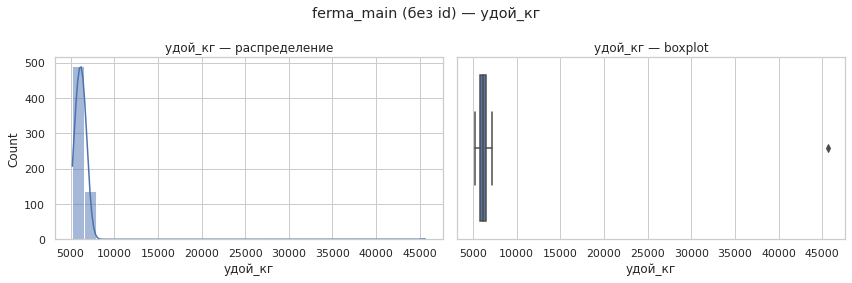

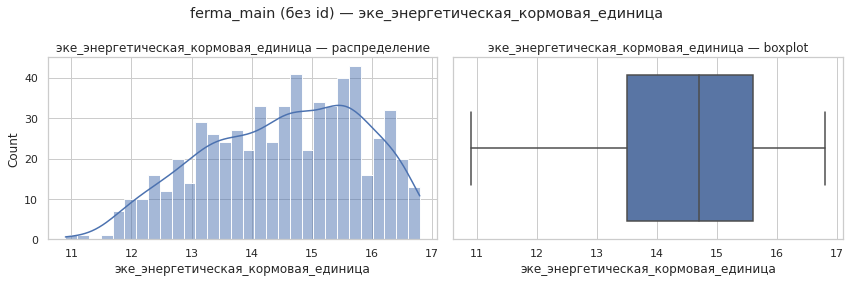

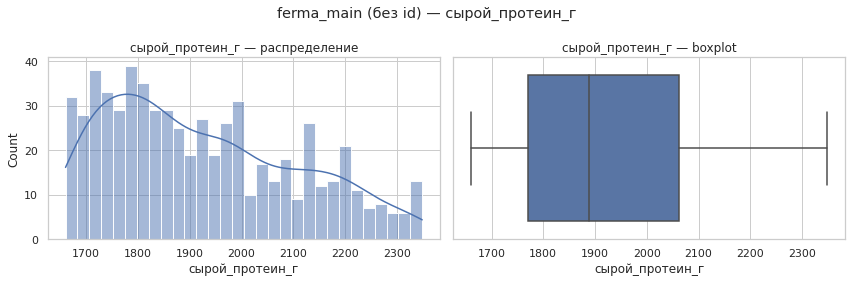

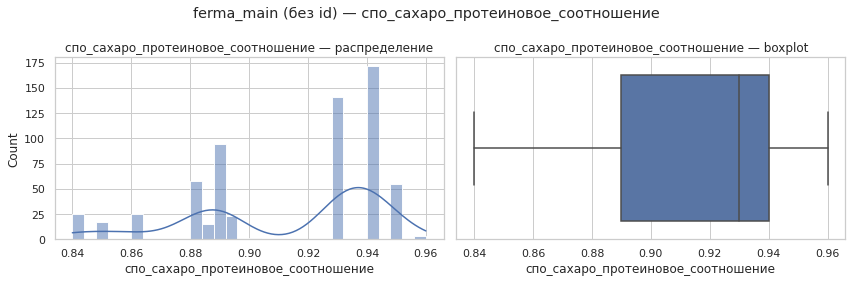

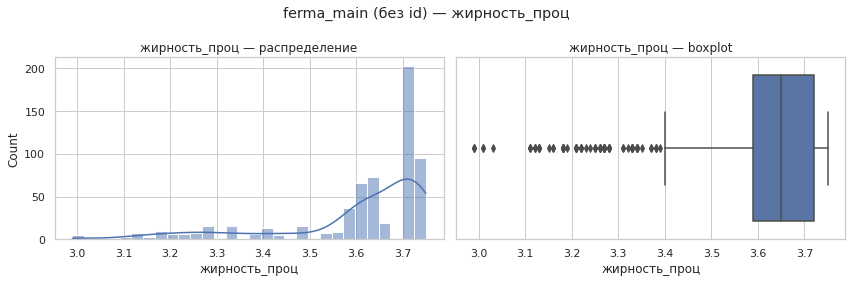

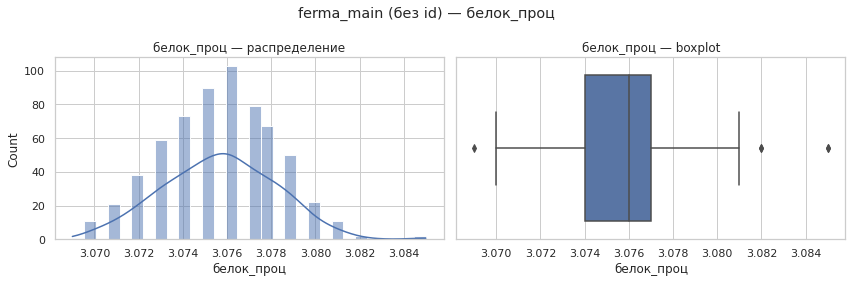

In [28]:
numeric_summary(ferma_main.drop(columns='id'), "ferma_main (без id)")
plot_numeric_distributions(ferma_main.drop(columns='id'), "ferma_main (без id)")

Видна явная аномалия в признаке `удой`. Распределение у остальных признаков кажется приемлимым. Рассмотрим подробнее аномалию. 

In [29]:
ferma_main.query('удой_кг > 8000')

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_проц,белок_проц,вкус_молока,возраст
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиалл,3.22,3.076,вкусно,более_2_лет


Скорее всего, это ошибка ввода данных, мы можем взять вместо него среднее, чтобы сохранить строку (это пример вкусного молока) и не искажать распределение. 

Статистика числовых признаков: ferma_main — удой_кг (после замены выброса)


,count,mean,std,min,25%,50%,75%,max
удой_кг,629.0,6125.968153,475.478035,5204.0,5751.0,6132.0,6501.0,7222.0


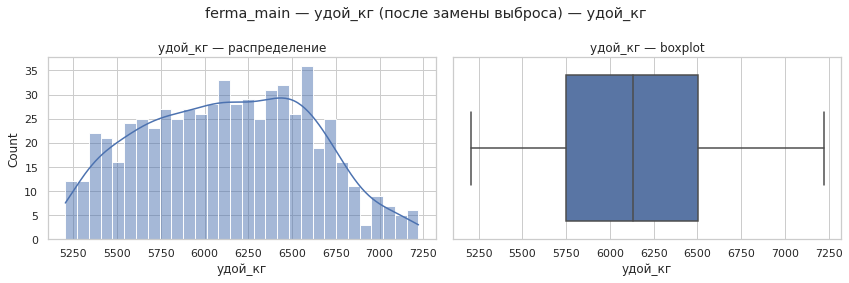

In [30]:
# Рассчитаем среднее значение без выброса
mean_udoy = ferma_main.query('удой_кг <= 8000')['удой_кг'].mean()

# Заменим выброс на это значение
ferma_main.loc[ferma_main['удой_кг'] > 8000, 'удой_кг'] = mean_udoy

# Статистика
numeric_summary(ferma_main[['удой_кг']], "ferma_main — удой_кг (после замены выброса)")

# Графики
plot_numeric_distributions(ferma_main[['удой_кг']], "ferma_main — удой_кг (после замены выброса)")

Теперь признак выглядит корректно.

### Категориальные признаки в ferma_main

Для начала изучим все уникальные значения категориальных признаков.

In [31]:
show_unique_categories(ferma_main, "ferma_main")

Уникальные значения категориальных признаков: ferma_main

порода: 2 уникальных значений
['Вис Бик Айдиал', 'РефлешнСоверинг']

тип_пастбища: 3 уникальных значений
['Равнинное', 'Равнинные', 'Холмистое']

порода_папы_быка: 3 уникальных значений
['Айдиал', 'Айдиалл', 'Соверин']

вкус_молока: 2 уникальных значений
['вкусно', 'не вкусно']

возраст: 2 уникальных значений
['более_2_лет', 'менее_2_лет']


Сразу можем заметить аномальные значения `Равнинные` и `Айдиалл`. Можем переименовать их в корректные.

In [32]:
# Исправление значений породы папы
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].replace({
    'Айдиалл': 'Айдиал'
})

# Исправление типа пастбища
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace({
    'Равнинные': 'Равнинное'
})

# Проверка
show_unique_categories(ferma_main, "ferma_main (после исправлений)")

Уникальные значения категориальных признаков: ferma_main (после исправлений)

порода: 2 уникальных значений
['Вис Бик Айдиал', 'РефлешнСоверинг']

тип_пастбища: 2 уникальных значений
['Равнинное', 'Холмистое']

порода_папы_быка: 2 уникальных значений
['Айдиал', 'Соверин']

вкус_молока: 2 уникальных значений
['вкусно', 'не вкусно']

возраст: 2 уникальных значений
['более_2_лет', 'менее_2_лет']


Теперь имеем 5 бинарных категориальных признаков. Изучим статистику.

Описательная статистика категориальных признаков: ferma_main


,count,unique,top,freq
порода,629,2,Вис Бик Айдиал,373
тип_пастбища,629,2,Холмистое,351
порода_папы_быка,629,2,Айдиал,318
вкус_молока,629,2,вкусно,371
возраст,629,2,более_2_лет,519


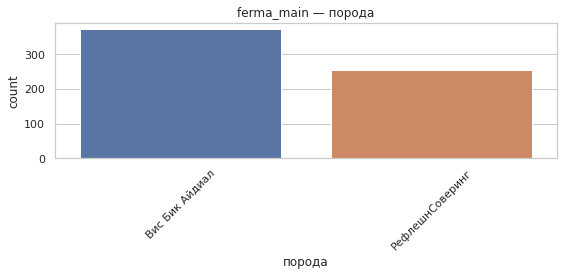

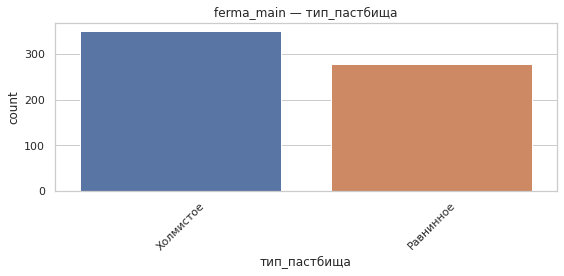

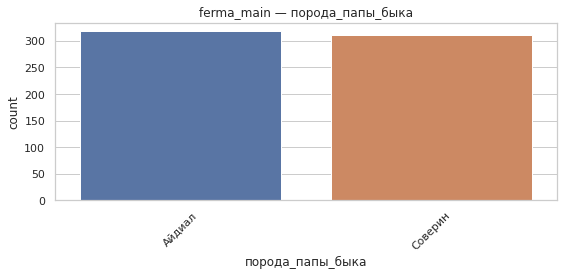

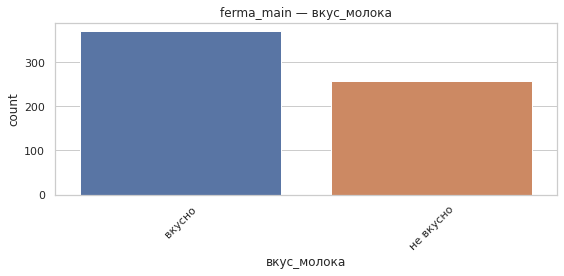

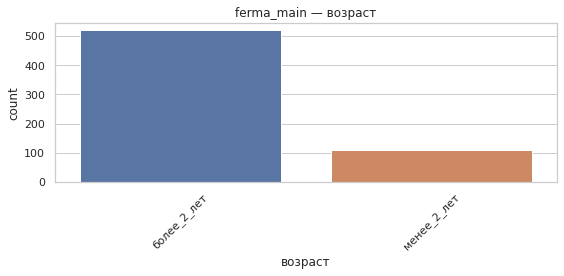

In [33]:
categorical_describe(ferma_main, "ferma_main")
plot_categorical_distributions(ferma_main, "ferma_main")

Категориальные признаки в `ferma_main` имеют по два уникальных значения каждый, без пропущенных значений. В выборке преобладают коровы породы «Вис Бик Айдиал», пасущиеся на холмистых пастбищах, с отцами породы «Айдиал», чаще с меткой «вкусно» по вкусу молока и преимущественно старше двух лет.

### Категориальные признаки в ferma_dad

Поскольку в `ferma_dad` только один информативный признак, изучим только его.

In [34]:
show_unique_categories(ferma_dad, "ferma_dad")

Уникальные значения категориальных признаков: ferma_dad

имя_папы: 4 уникальных значений
['Барин', 'Буйный', 'Геркулес', 'Соловчик']


Описательная статистика категориальных признаков: ferma_dad


,count,unique,top,freq
имя_папы,629,4,Барин,240


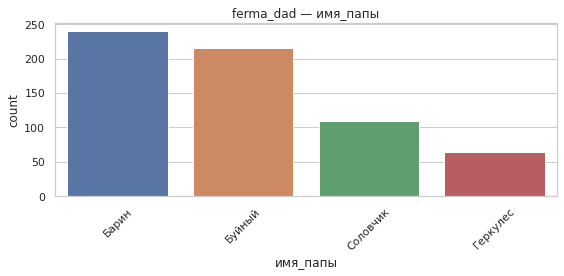

In [35]:
categorical_describe(ferma_dad, "ferma_dad")
plot_categorical_distributions(ferma_dad, "ferma_dad")

Признак `имя_папы` в `ferma_dad` содержит 4 уникальных значения без пропусков. Наиболее распространённое имя - «Барин» (240 случаев), за ним следуют «Буйный» и «Соловчик», а наименее встречающееся - «Геркулес».

### Числовые признаки в cow_buy

Теперь изучим числовые признаки в `cow_buy`.

Статистика числовых признаков: cow_buy


,count,mean,std,min,25%,50%,75%,max
текущая_жирность_проц,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
текущий_уровень_белок_проц,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


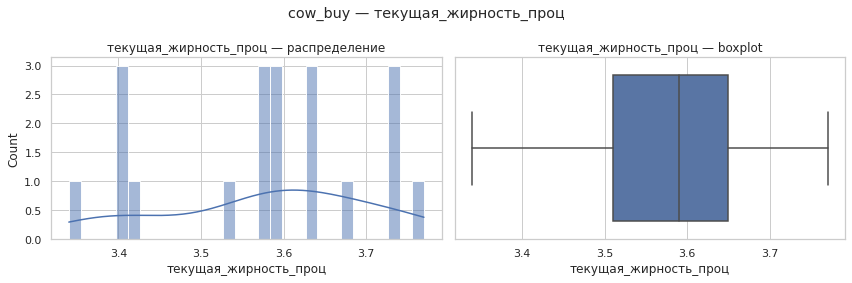

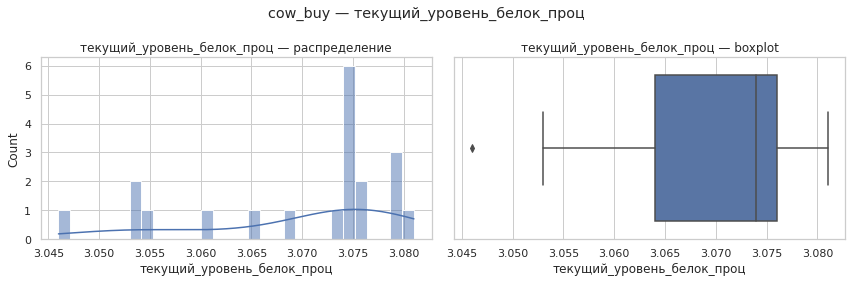

In [36]:
numeric_summary(cow_buy, "cow_buy")
plot_numeric_distributions(cow_buy, "cow_buy")

Распределения адекватные, аномалий не наблюдается. Значения близки к тем, что были у коров фермера.

### Категориальные признаки в cow_buy

In [37]:
show_unique_categories(cow_buy, "cow_buy")

Уникальные значения категориальных признаков: cow_buy

порода: 2 уникальных значений
['Вис Бик Айдиал', 'РефлешнСоверинг']

тип_пастбища: 2 уникальных значений
['равнинное', 'холмистое']

порода_папы_быка: 2 уникальных значений
['Айдиал', 'Соверин']

имя_папы: 4 уникальных значений
['Барин', 'Буйный', 'Геркулес', 'Соловчик']

возраст: 2 уникальных значений
['более_2_лет', 'менее_2_лет']


Сделаем значения в `тип_пастбища` с большой буквы, чтобы были аналогичны `ferma_main`.

In [38]:
cow_buy['тип_пастбища'] = cow_buy['тип_пастбища'].str.capitalize()

Описательная статистика категориальных признаков: cow_buy


,count,unique,top,freq
порода,20,2,РефлешнСоверинг,11
тип_пастбища,20,2,Равнинное,11
порода_папы_быка,20,2,Соверин,12
имя_папы,20,4,Буйный,8
возраст,20,2,более_2_лет,15


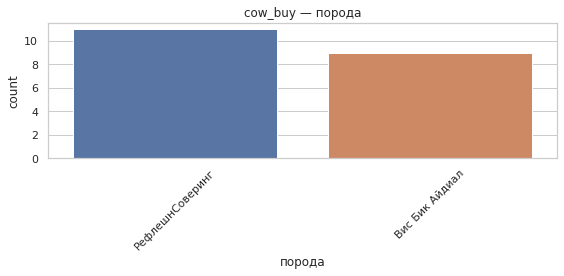

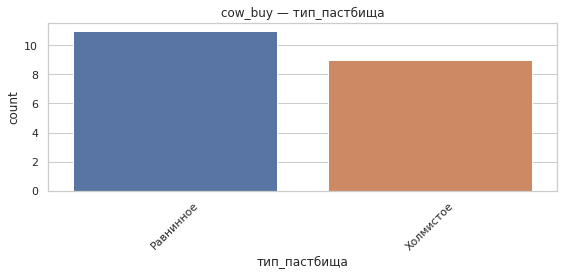

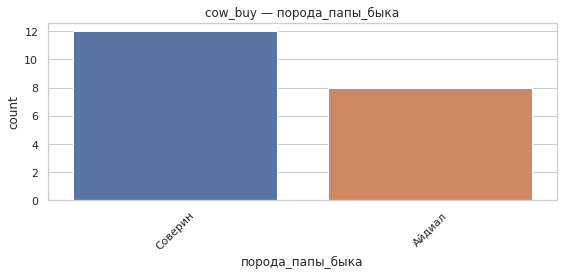

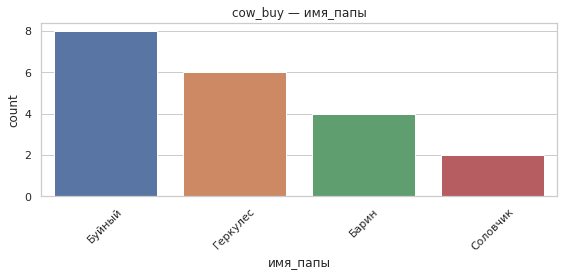

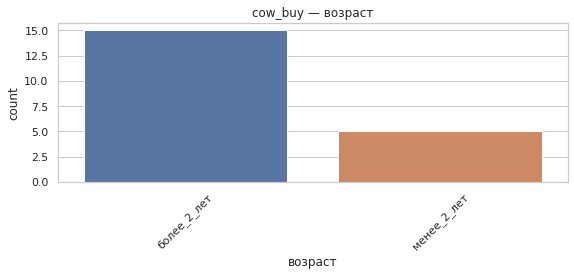

In [39]:
categorical_describe(cow_buy, "cow_buy")
plot_categorical_distributions(cow_buy, "cow_buy")

В выборке представлены две породы и два типа пастбищ в равных долях. Порода отца «Соверин» преобладает, а среди имён отцов наиболее часто встречается «Буйный». Большинство коров - старше двух лет (11 из 16). Распределения сбалансированы, аномалий или опечаток не выявлено.

Таким образом, мы провели исследовательский анализ данных.

## Корреляционный анализ

Проведем корреляционный анализ признаков в датасете `ferma_main.csv`. <br>
Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.

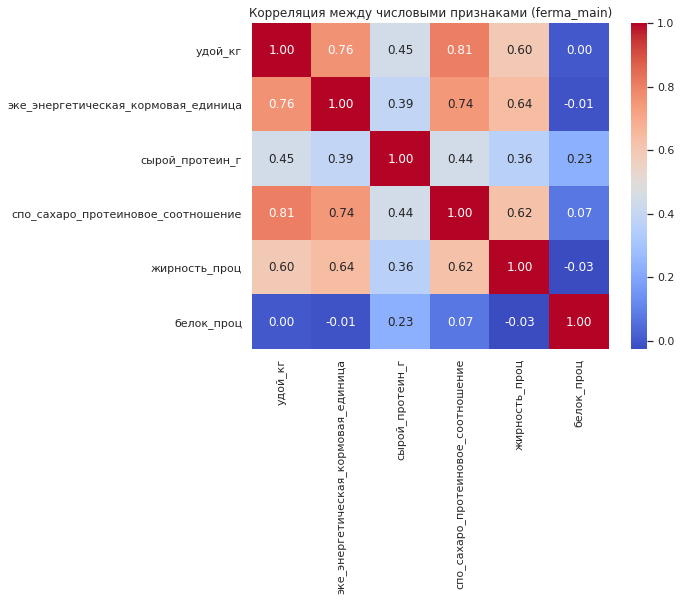

In [40]:
# Выбираем только числовые признаки без id
numeric_cols = ferma_main.select_dtypes(include='number').drop(columns='id')

# Расчёт матрицы корреляций
corr_matrix = numeric_cols.corr(method='pearson')

# Отображение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция между числовыми признаками (ferma_main)")
plt.show()

interval columns not set, guessing: ['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро_протеиновое_соотношение', 'жирность_проц', 'белок_проц']


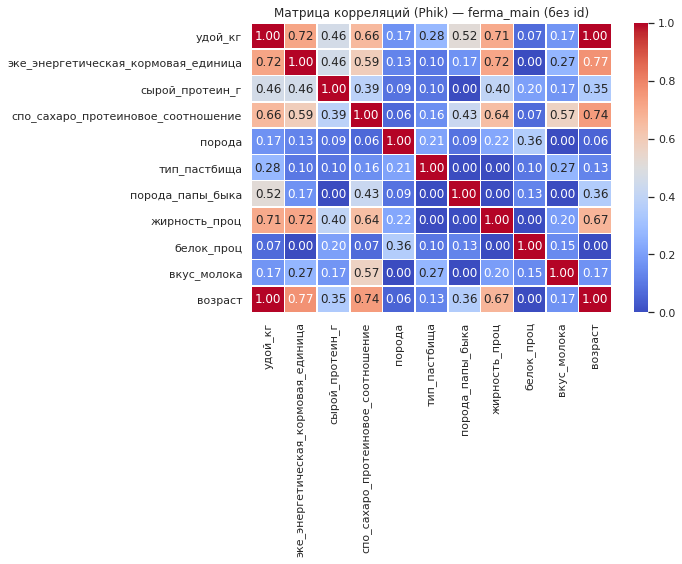

In [41]:
# Создаём копию без id
df_phik = ferma_main.drop(columns='id')

# Считаем phik-корреляции
phik_corr = df_phik.phik_matrix(interval_cols=None)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций (Phik) — ferma_main (без id)")
plt.tight_layout()
plt.show()

Анализ корреляции показал, что наибольшее влияние на удой оказывают признаки энергетической кормовой единицы, сахаропротеинового соотношения и жирности молока, что подтверждается как коэффициентом Пирсона, так и φ-корреляцией. Белок практически не связан с другими признаками. 

Дополнительно, с использованием φ-корреляции удалось выявить умеренную зависимость удоя от породы отца и сильную от возраста коровы (100%!), а также заметную связь вкуса молока с спо. Это указывает на значимость как числовых, так и категориальных признаков, которые следует учитывать при построении моделей.

Построим диаграммы рассеяния `scatterplot` для признака `Удой, кг` и всех количественных признаков с учётом значения категориальных признаков.

In [42]:
# Функция для построения scatterplot'ов
def scatter_grid(df, x_col, y_col, cat_cols):
    n = len(cat_cols)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, cat_col in enumerate(cat_cols):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=cat_col, ax=axes[i])
        axes[i].set_title(f"{y_col} vs {x_col}\n(hue={cat_col})")

    # Отключаем лишние подграфики
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

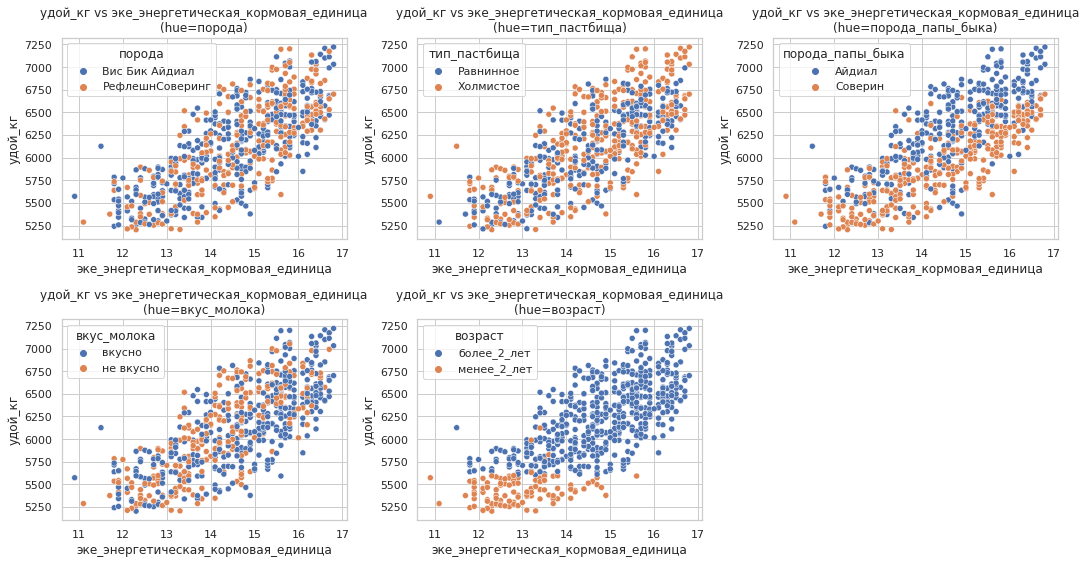

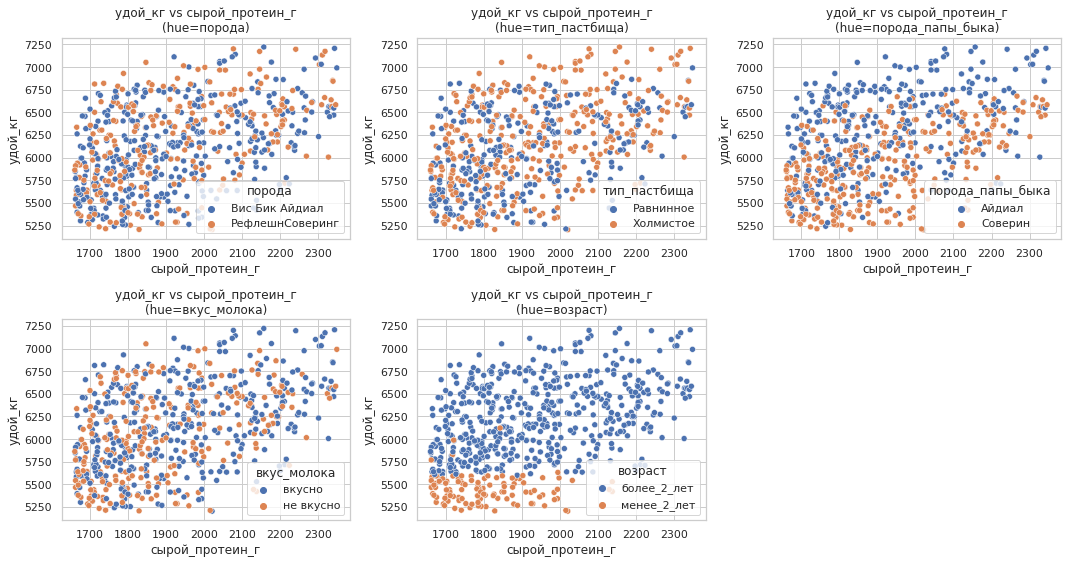

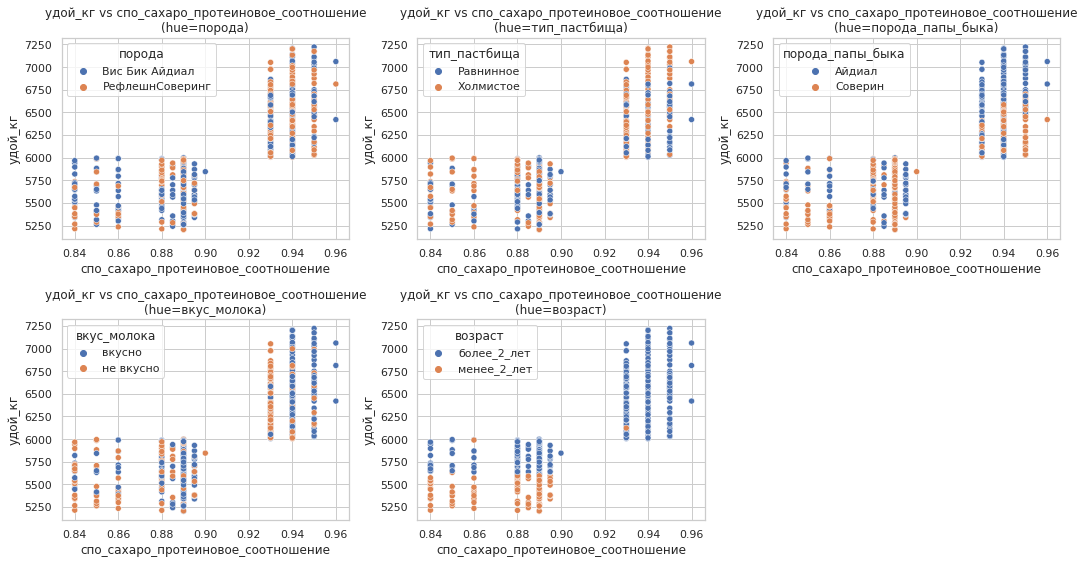

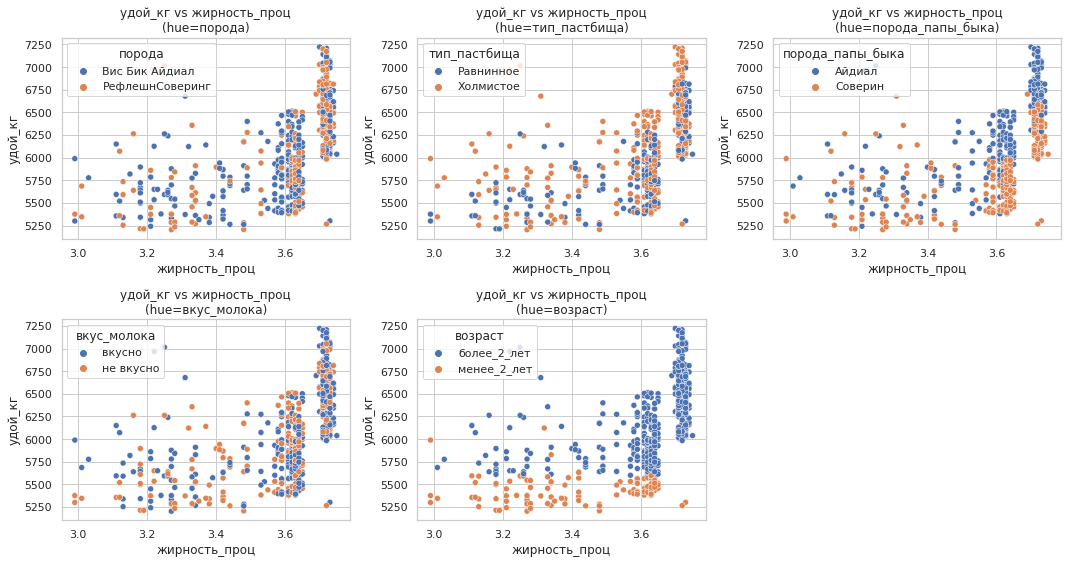

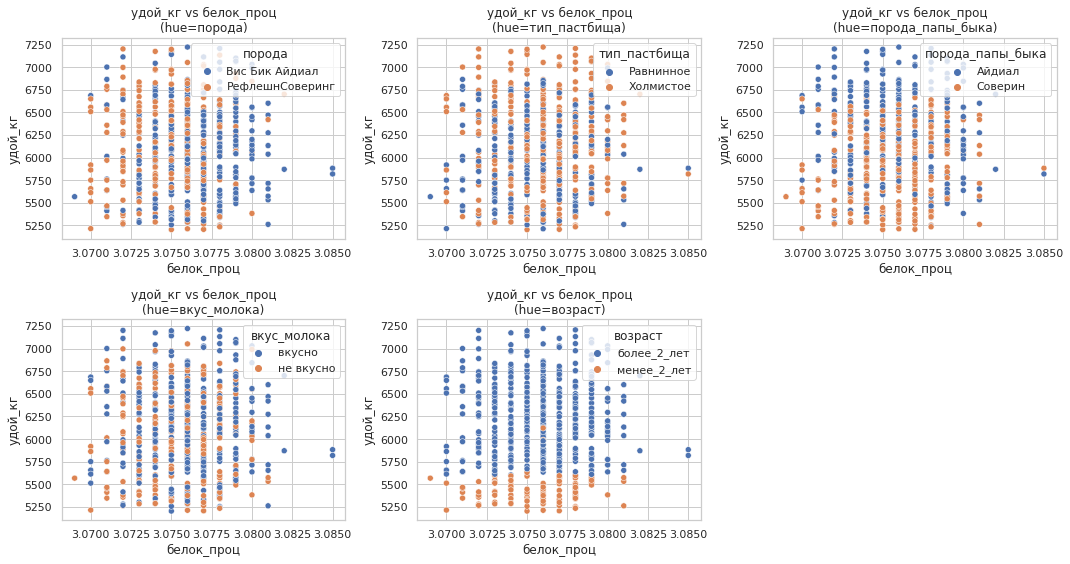

In [43]:
# Список числовых и категориальных признаков
numeric_cols = [
    'эке_энергетическая_кормовая_единица',
    'сырой_протеин_г',
    'спо_сахаро_протеиновое_соотношение',
    'жирность_проц',
    'белок_проц'
]

categorical_cols = [
    'порода',
    'тип_пастбища',
    'порода_папы_быка',
    'вкус_молока',
    'возраст'
]

# Построение по всем числовым
for num_col in numeric_cols:
    scatter_grid(ferma_main, x_col=num_col, y_col='удой_кг', cat_cols=categorical_cols)

Анализ диаграмм рассеяния показывает, что между удоем и рядом количественных признаков существует ярко выраженная зависимость, однако характер этой зависимости различается по группам категориальных признаков. Особенно чёткая взаимосвязь наблюдается между удоем и энергетической кормовой единицей: в каждой подгруппе (по породе, возрасту, вкусу молока и т.д.) прослеживается положительная связь, хотя и с разной степенью выраженности. При этом влияние возраста выглядит особенно сильным - коровы старше двух лет демонстрируют значительно больший разброс и уровни удоя, что согласуется с результатами φ-корреляции.

Нелинейность особенно заметна при рассмотрении признаков жирности и сахаропротеинового соотношения (в целом, в разной степени для всех, кроме эке) - при высоких значениях этих признаков наблюдается насыщение или сужение диапазона удоев. В ряде графиков можно заметить “ступенчатость” распределений, особенно для признака `спо`, что указывает на дискретность значений или особенности округления в данных. Для учёта потенциальной нелинейности в модели стоит рассмотреть введение полиномиальных признаков или взаимодействий между признаками - особенно для пар `эке × возраст`, `спо × вкус`, `жирность × тип пастбища`.

Мультиколлинеарность частично проявляется в высокой корреляции между признаками `эке`, `спо` и `жирность`, а также в похожем характере распределений на scatter-графиках. Особенно это заметно в категориях, где одни и те же группы показывают схожие сдвиги сразу по нескольким признакам. Это указывает на возможность дублирующей информации между этими переменными.

## Обучение модели линейной регрессии

### Первая модель

Подготовим данные датасета `ferma_main.csv` и обучим на них первую модель `LinearRegression`.<br>
Используем в качестве целевого признак `Удой, кг`.

Отберем признаки, которые подходят для модели линейной регрессии.

В первую очередь, берем признаки с высокой и заметной корреляцией:
- `эке_энергетическая_кормовая_единица` (0.76)
- `спо_сахаро_протеиновое_соотношение` (0.81)
- `возраст` - высокая φ-корреляция (1.0), подтверждается графиками
- `порода_папы_быка` (0.52) - заметная φ-корреляция, подтверждается графиками 
- `порода` и `тип_пастбища` (0.17 и 0.28) - слабая связь, но логически должны влиять на удой


Признак `белок_проц` можем исключить из-за слабой корреляции (0) и ступенчатости на графиках.<br>
Признак `вкус_молока` - это оценка фермера и таргет для задачи классификации.<br>
Признак `жирность_проц` - заметная корреляция (0.6), но описывает само молоко.<br>
Признак `сырой_протеин_г` - связь с удоем умеренная (0.45), может дублировать `эке` и `спо`, по графикам нелинейная связь

Разделим данные на `X` и `y`, затем - на обучающую и тестовую выборки.

In [44]:
# Признаки и целевая переменная
features = [
    'эке_энергетическая_кормовая_единица',
    'спо_сахаро_протеиновое_соотношение',
    'возраст',
    'порода_папы_быка',
    'порода',
    'тип_пастбища'
]
target = 'удой_кг'

X = ferma_main[features]
y = ferma_main[target]

# Разбиение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Теперь закодируем категориальные признаки и масштабируем числовые.

In [45]:
# Категориальные и числовые признаки
cat_features = ['возраст', 'порода_папы_быка', 'порода', 'тип_пастбища']
num_features = ['эке_энергетическая_кормовая_единица', 
                'спо_сахаро_протеиновое_соотношение']

# Трансформер для one-hot кодирования и StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

# Применяем трансформацию
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

Осталось обучить модель.

In [46]:
# Создание и обучение модели
model = LinearRegression()
model.fit(X_train_prepared, y_train)

LinearRegression()

Проверим результаты.

In [47]:
# Функция для анализа метрик и остатков
def evaluate_regression_model(y_true, y_pred, model_name="Модель"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"Оценка модели: {model_name}")
    print(f"R2:   {r2:.3f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    residuals = y_true - y_pred

    # График остатков
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанный удой")
    plt.ylabel("Остатки")
    plt.title(f"Остатки: {model_name}")
    plt.tight_layout()
    plt.show()

Оценка модели: Линейная регрессия (первая)
R2:   0.804
MAE:  199.70
RMSE: 239.50


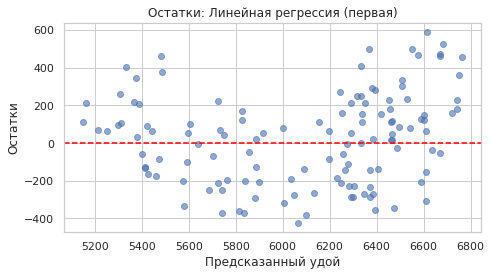

In [48]:
y_pred = model.predict(X_test_prepared)
evaluate_regression_model(y_test, y_pred, model_name="Линейная регрессия (первая)")

Модель линейной регрессии показывает стабильное качество: коэффициент детерминации R2 составляет 0.804, что указывает на высокий уровень объяснённой дисперсии целевого признака. Средняя абсолютная ошибка (MAE) равна 199.7 кг, а среднеквадратичная ошибка (RMSE) - 239.5 кг, что соответствует умеренным отклонениям между предсказанными и фактическими значениями. График остатков демонстрирует лёгкую асимметрию и неоднородность распределения ошибок: на участках с низким и высоким предсказанным удоем заметны систематические отклонения, что может свидетельствовать о влиянии нелинейных зависимостей.

### Вторая модель

Попробуем в некоторых признаках убрать нелинейность и построить вторую модель.

Признак `спо_сахаро_протеиновое_соотношение`:<br>
На диаграммах рассеяния видно, что данные по СПО образуют два явных кластера. Граница между ними - примерно на уровне 0.91.
Поэтому заменим этот признак на бинарный: `спо_высокий = 1`, если СПО ≥ 0.91, иначе 0.

Признак `эке_энергетическая_кормовая_единица`:<br>
Для него видно квадратичную зависимость (сгибается вверх). Поэтому добавим признак `эке_в_квадрате`.

In [49]:
# Копия исходных данных
ferma_main_v2 = ferma_main.copy()

# Бинаризация СПО
ferma_main_v2['спо_высокий'] = (ferma_main_v2['спо_сахаро_протеиновое_соотношение'] >= 0.91).astype(int)

# Признак ЭКЕ в квадрате
ferma_main_v2['эке_в_квадрате'] = ferma_main_v2['эке_энергетическая_кормовая_единица'] ** 2

Проделаем подготовку данных аналогично первой модели.

In [50]:
# Обновлённый набор признаков
features_v2 = [
    'эке_в_квадрате',
    'спо_высокий',
    'возраст',
    'порода_папы_быка',
    'порода',
    'тип_пастбища'
]
target = 'удой_кг'

# Разделение
X_v2 = ferma_main_v2[features_v2]
y_v2 = ferma_main_v2[target]

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42
)

In [51]:
# Обновлённые группы признаков
cat_features_v2 = ['возраст', 'порода_папы_быка', 'порода', 'тип_пастбища'] # спо_высокий — уже бинарный
num_features_v2 = ['эке_в_квадрате']  

# Препроцессор
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features_v2),
        ('num', StandardScaler(), num_features_v2)
    ]
)

# Применение
X_train_v2_prepared = preprocessor_v2.fit_transform(X_train_v2)
X_test_v2_prepared = preprocessor_v2.transform(X_test_v2)

In [52]:
model_v2 = LinearRegression()
model_v2.fit(X_train_v2_prepared, y_train_v2)

LinearRegression()

Оценка модели: Линейная регрессия (вторая)
R2:   0.772
MAE:  209.56
RMSE: 258.69


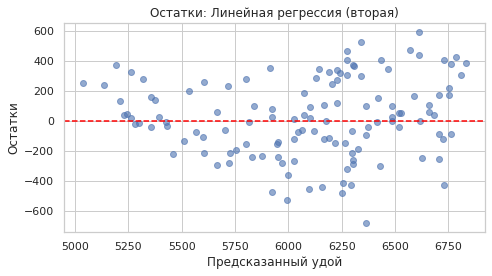

In [53]:
y_pred_v2 = model_v2.predict(X_test_v2_prepared)
evaluate_regression_model(y_test_v2, y_pred_v2, model_name="Линейная регрессия (вторая)")

Модель линейной регрессии с преобразованными признаками показывает немного более низкое качество по сравнению с первой: коэффициент детерминации R2 составляет 0.772 против 0.804, что указывает на некоторое снижение доли объяснённой дисперсии. Ошибки модели также несколько выше - MAE составляет 209.6 кг, а RMSE - 258.7 кг. Эти значения демонстрируют более выраженные отклонения предсказаний от фактических значений по сравнению с базовой моделью. Анализ графика остатков показывает усиление неоднородности: в средней зоне предсказаний наблюдаются систематические ошибки, а по краям - более сильные флуктуации. Несмотря на добавление признаков `эке_в_квадрате` и `спо_высокий`, полное устранение нелинейных эффектов не достигнуто. Таким образом, трансформации признаков в данной конфигурации оказались полезными, но не обеспечили улучшения модели - она уступает первой как по точности, так и по стабильности ошибок.

### Третья модель

Для третьей модели добавим признак `Имя Папы` из файла `ferma_dad.csv`, соединив его с остальными данными `ferma_main.csv` по ключу.

In [54]:
# Копия с признаками первой модели
ferma_main_v3 = ferma_main.copy()

# Объединение по id
ferma_main_v3 = ferma_main_v3.merge(ferma_dad, on='id', how='left')

# Проверка корректности объединения
print(f"Кол-во строк после объединения: {ferma_main_v3.shape[0]}")
print(f"Пропуски в 'имя_папы': {ferma_main_v3['имя_папы'].isna().sum()}")
print(f"Уникальные значения 'имя_папы': {ferma_main_v3['имя_папы'].nunique()}")
print(f"Примеры значений: {ferma_main_v3['имя_папы'].unique()}")

Кол-во строк после объединения: 629
Пропуски в 'имя_папы': 0
Уникальные значения 'имя_папы': 4
Примеры значений: ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


Отлично, объединение прошло корректно. Составим список признаков для третьей модели и проделаем всё те же действия.

In [55]:
features_v3 = [
    'эке_энергетическая_кормовая_единица',
    'спо_сахаро_протеиновое_соотношение',
    'возраст',
    'порода_папы_быка',
    'порода',
    'тип_пастбища',
    'имя_папы'
]
target = 'удой_кг'

In [56]:
X_v3 = ferma_main_v3[features_v3]
y_v3 = ferma_main_v3[target]

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
    X_v3, y_v3, test_size=0.2, random_state=42
)

In [57]:
# Категориальные и числовые признаки
cat_features_v3 = ['возраст', 'порода_папы_быка', 'порода', 'тип_пастбища', 'имя_папы']
num_features_v3 = ['эке_энергетическая_кормовая_единица', 
                'спо_сахаро_протеиновое_соотношение'] 

# Комбинированный препроцессор
preprocessor_v3 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features_v3),
        ('num', StandardScaler(), num_features_v3)
    ]
)

X_train_v3_prepared = preprocessor_v3.fit_transform(X_train_v3)
X_test_v3_prepared = preprocessor_v3.transform(X_test_v3)

In [58]:
model_v3 = LinearRegression()
model_v3.fit(X_train_v3_prepared, y_train_v3)

LinearRegression()

Оценка модели: Линейная регрессия (третья)
R2:   0.821
MAE:  186.41
RMSE: 229.13


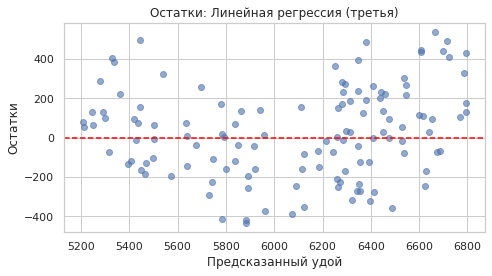

In [59]:
y_pred_v3 = model_v3.predict(X_test_v3_prepared)
evaluate_regression_model(y_test_v3, y_pred_v3, model_name="Линейная регрессия (третья)")

Третья модель линейной регрессии, дополненная признаком `имя_папы`, смогла превзойти по качеству первую модель. Значение R2 составило 0.821, что выше результата базовой модели (0.804), а также метрики ошибок MAE и RMSE оказались ниже - 186.41 кг и 229.13 кг соответственно. Это свидетельствует о большей точности предсказаний и повышении доли объяснённой дисперсии.

График остатков выглядит достаточно симметричным, добавление признака `имя_папы` могло внести частичную дополнительную информацию, отражающую генетические особенности. Таким образом, третья модель подтверждает, что включение новых признаков может быть полезным, но должно сопровождаться тщательной проверкой их полезности.

### Явное сравнение моделей

Сравним модели более наглядно.

In [60]:
# Функция сравнения моделей
def compare_regression_models(model_results, y_train_full=None, y_train_pred=None, alpha=0.95):
    """
    model_results — список кортежей: (название, y_true, y_pred)
    y_train_full, y_train_pred — для доверительного интервала лучшей модели
    alpha - уровень доверия
    """
    comparison = []
    residual_plots = []

    for name, y_true, y_pred in model_results:
        r2 = r2_score(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        residuals = y_true - y_pred

        comparison.append({
            "Модель": name,
            "R2": round(r2, 3),
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "MSE": round(mse, 2)
        })

        residual_plots.append((name, y_pred, residuals))

    # Вывод таблицы
    df = pd.DataFrame(comparison).sort_values("R2", ascending=False)
    display(df)

    # Лучшая модель
    best_model_name = df.iloc[0]["Модель"]
    print(f"Лучшая модель по R2: {best_model_name}")

    # Остатки — графики
    n = len(residual_plots)
    cols = 2
    rows = (n + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    axes = axes.flatten()

    for i, (name, y_pred, residuals) in enumerate(residual_plots):
        ax = axes[i]
        ax.scatter(y_pred, residuals, alpha=0.6)
        ax.axhline(0, color='red', linestyle='--')
        ax.set_title(f"{name} — остатки")
        ax.set_xlabel("Предсказанный удой")
        ax.set_ylabel("Остатки")

    # Удалим пустые оси (если нечетное количество графиков, у нас 3)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Доверительный интервал по обучающей выборке
    if y_train_full is not None and y_train_pred is not None:
        residuals_train = y_train_full - y_train_pred
        lower = np.quantile(residuals_train, (1 - alpha) / 2)
        upper = np.quantile(residuals_train, 1 - (1 - alpha) / 2)
        print(f"\nДоверительный интервал ошибок (на обучении, {int(alpha*100)}%):")
        print(f"от {lower:.2f} до {upper:.2f}")

,Модель,R2,MAE,RMSE,MSE
2,Линейная регрессия (третья),0.821,186.41,229.13,52501.19
0,Линейная регрессия (первая),0.804,199.70,239.50,57360.04
1,Линейная регрессия (вторая),0.772,209.56,258.69,66919.09


Лучшая модель по R2: Линейная регрессия (третья)


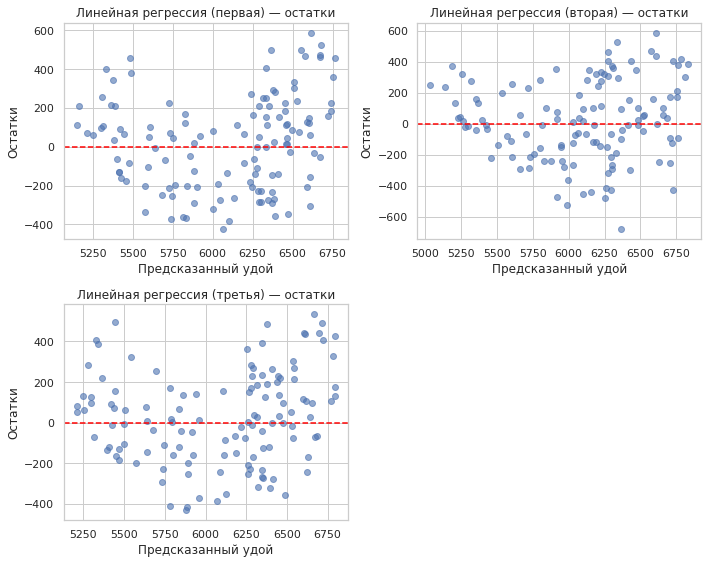


Доверительный интервал ошибок (на обучении, 95%):
от -377.00 до 389.06


In [61]:
y_train_pred_v3 = model_v3.predict(X_train_v3_prepared)

compare_regression_models(
    model_results=[
        ("Линейная регрессия (первая)", y_test, y_pred),
        ("Линейная регрессия (вторая)", y_test_v2, y_pred_v2),
        ("Линейная регрессия (третья)", y_test_v3, y_pred_v3)
    ],
    y_train_full=y_train_v3,
    y_train_pred=y_train_pred_v3
)

Сравнение трёх моделей линейной регрессии показало, что наилучшее качество демонстрирует третья модель. Она достигла самого высокого значения R2 - 0.821, а также наименьших значений ошибок: MAE составила 186.41 кг, RMSE - 229.13 кг. Вторая и первая модели оказались менее точными как по доле объяснённой дисперсии, так и по значениям ошибок, несмотря на применение дополнительных признаков и трансформаций.

Анализ графиков остатков подтверждает это: остатки третьей модели ближе к случайному шуму, в то время как у второй и первой моделей наблюдаются более выраженные отклонения. Особенно заметна асимметрия и вытянутость у второй модели, что может указывать на переобучение или избыточность признаков.

Дополнительно был рассчитан доверительный интервал ошибок на обучающей выборке. При уровне доверия 95% можно ожидать, что предсказания модели будут отклоняться от реальных значений в диапазоне от -377.00 до 389.06. Это позволяет фермерам учитывать возможный разброс при планировании продуктивности стада.

Таким образом, третья модель остаётся наиболее сбалансированной и надёжной для задачи прогнозирования удоя. Дополнительный признак `имя_папы` улучшил качество, что подтверждает важность тщательного отбора переменных в линейных моделях.

### Прогноз удоя

С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить.

Добавим недостающие признаки `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)`: возьмем из датасета `ferma_main.csv` средние значения каждого из признаков и увеличим их на 5%. Далее выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.

In [62]:
# Средние значения по ferma_main
eke_mean = ferma_main['эке_энергетическая_кормовая_единица'].mean() * 1.05
protein_mean = ferma_main['сырой_протеин_г'].mean() * 1.05
spo_mean = ferma_main['спо_сахаро_протеиновое_соотношение'].mean() * 1.05

# Копия cow_buy
cow_buy_v3 = cow_buy.copy()

# Добавим признаки
cow_buy_v3['эке_энергетическая_кормовая_единица'] = eke_mean
cow_buy_v3['сырой_протеин_г'] = protein_mean
cow_buy_v3['спо_сахаро_протеиновое_соотношение'] = spo_mean

In [63]:
X_cow_buy = cow_buy_v3[features_v3]  # те же признаки, что в третьей модели

In [64]:
# Подготовим данные через тот же препроцессор
X_cow_buy_prepared = preprocessor_v3.transform(X_cow_buy)

# Прогноз
y_cow_pred = model_v3.predict(X_cow_buy_prepared)

# Добавим к результату
cow_buy_v3['прогноз_удой'] = y_cow_pred

In [65]:
display(cow_buy_v3)

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_проц,текущий_уровень_белок_проц,возраст,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,прогноз_удой
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271073,2019.532273,0.958772,6430.309652
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,2019.532273,0.958772,6350.577792
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271073,2019.532273,0.958772,6712.892727
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271073,2019.532273,0.958772,6637.643550
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271073,2019.532273,0.958772,6473.468264
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271073,2019.532273,0.958772,6626.141951
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,2019.532273,0.958772,6350.577792
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.271073,2019.532273,0.958772,6517.060428


На основе обученной модели линейной регрессии был выполнен прогноз годового удоя для 20 коров, предложенных к покупке. Согласно результатам, все животные демонстрируют ожидаемый удой в диапазоне от 6184 до 6712 кг, что превышает минимальные производственные требования фермера. Ни одна из коров не показала прогноз ниже 6000 кг, а большая часть - уверенно превышает порог в 6300 кг. Это свидетельствует о высоком потенциальном уровне продуктивности стада и подтверждает пригодность большинства предложенных животных для расширения фермерского хозяйства.

## Обучение модели логистической регрессии

Теперь нам нужно спрогнозировать вкус молока, ведь второе условие фермера - "молоко должно быть вкусным".

Подготовим данные датасета `ferma_main.csv` и обучим на них модель `LogisticRegression`.

Используем в качестве целевого признак `Вкус молока`. Ещё раз убедимся, что он бинарный.

In [66]:
ferma_main['вкус_молока'].value_counts()

вкусно       371
не вкусно    258
Name: вкус_молока, dtype: int64

Возьмём в основу те же признаки, что были в первой модели регрессии (они уже хорошо подготовлены и обоснованы), а также добавим признаки, описывающие молоко.

In [67]:
features_classification = [
    'эке_энергетическая_кормовая_единица',
    'спо_сахаро_протеиновое_соотношение',
    'возраст',
    'порода_папы_быка',
    'порода',
    'тип_пастбища',
    'жирность_проц'
]
target_classification = 'вкус_молока'

Преобразуем `вкусно` и `не вкусно` в `1` и `0`.

In [68]:
ferma_main['вкус_молока'] = (ferma_main['вкус_молока'] == 'вкусно').astype(int)

Теперь выполним остальную подготовку.

In [69]:
X_cls = ferma_main[features_classification]
y_cls = ferma_main[target_classification]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls) # сохраняем пропорции классов

In [70]:
cat_features_cls = ['возраст', 'порода_папы_быка', 'порода', 'тип_пастбища']
num_features_cls = ['эке_энергетическая_кормовая_единица', 'спо_сахаро_протеиновое_соотношение', 'жирность_проц']

preprocessor_cls = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features_cls),
        ('num', StandardScaler(), num_features_cls)
    ]
)

X_train_cls_prepared = preprocessor_cls.fit_transform(X_train_cls)
X_test_cls_prepared = preprocessor_cls.transform(X_test_cls)

In [71]:
# Создание модели и fit
model_cls = LogisticRegression(random_state=42)
model_cls.fit(X_train_cls_prepared, y_train_cls)

LogisticRegression(random_state=42)

Отлично, посмотрим на метрики и матрицу ошибок.

In [72]:
# Функция оценки модели классификации
def evaluate_classification_model(y_true, y_pred, model_name="Модель"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    print(f"Оценка модели: {model_name}")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['не вкусно', 'вкусно'])
    disp.plot(cmap='Blues')
    plt.title(f"Матрица ошибок — {model_name}")
    plt.tight_layout()
    plt.show()

Оценка модели: Логистическая регрессия
Accuracy:  0.611
Precision: 0.617
Recall:    0.892


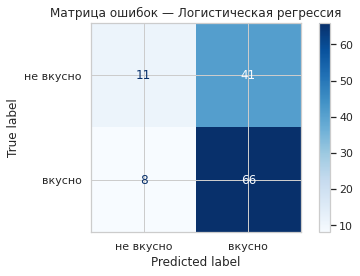

In [73]:
y_pred_cls = model_cls.predict(X_test_cls_prepared)
evaluate_classification_model(y_test_cls, y_pred_cls, model_name="Логистическая регрессия")

Модель логистической регрессии показала умеренное качество классификации: точность составила 61.1%, средняя абсолютная точность предсказаний на положительный класс - 61.7%, а полнота - 89.2%. Матрица ошибок указывает на заметный перекос в сторону предсказания класса «вкусно», однако в целом модель демонстрирует стабильную работу и может использоваться для предварительного отбора коров по вкусовым качествам молока.

### Улучшение модели

Рассмотим, какая из ошибок для фермера критичнее:
- Ошибка первого рода (False Positive): модель считает молоко вкусным, а оно на самом деле невкусное. Следовательно, фермер покупает плохую корову. Это критично.
- Ошибка второго рода (False Negative): модель считает молоко невкусным, а оно вкусное. Следовательно, фермер не покупает хорошую корову. Потери, но не прямой вред.

Таким образом, для заказчика важнее <b> не купить корову с невкусным молоком</b>, даже если несколько хороших будут упущены.

Значит, критичнее ошибка первого рода, и важнее метрика Precision (точность) - доля действительно «вкусных» среди предсказанных «вкусных».

Изменим порог, чтобы минимизировать ошибки первого рода.

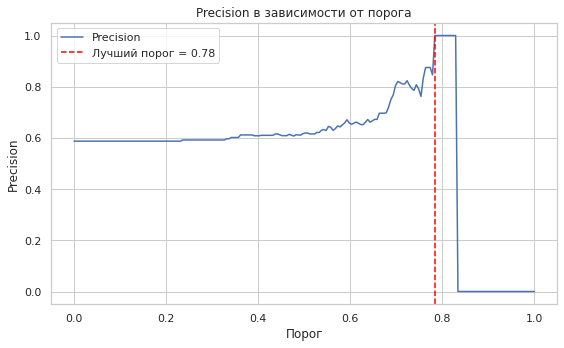

Максимальный precision: 1.000 при пороге: 0.78


In [74]:
y_proba_cls = model_cls.predict_proba(X_test_cls_prepared)[:, 1]  # вероятность класса "вкусно"

# Расчёт precision для разных порогов
thresholds = np.linspace(0, 1, 200)
precisions = []

for threshold in thresholds:
    y_pred_threshold = (y_proba_cls >= threshold).astype(int)
    precision = precision_score(y_test_cls, y_pred_threshold, zero_division=0)
    precisions.append(precision)

# Поиск порога с максимальным precision
best_threshold = thresholds[np.argmax(precisions)]
best_precision = max(precisions)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший порог = {best_threshold:.2f}')
plt.title("Precision в зависимости от порога")
plt.xlabel("Порог")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Вывод оптимального порога
print(f"Максимальный precision: {best_precision:.3f} при пороге: {best_threshold:.2f}")

Оценка модели: Порог = 0.78
Accuracy:  0.468
Precision: 1.000
Recall:    0.095


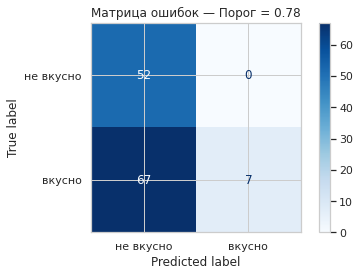

In [75]:
# Предсказания с оптимальным порогом
y_pred_cls_best = (y_proba_cls >= best_threshold).astype(int)

# Оценка модели с новым порогом
evaluate_classification_model(y_test_cls, y_pred_cls_best, model_name=f"Порог = {best_threshold:.2f}")

Изменение порога на 0.78 полностью устранило наиболее критичную ошибку - модель ни разу не предсказала невкусное молоко как вкусное. Это обеспечило максимальную точность (Precision = 1.000), что особенно важно для заказчика. Однако за надёжность пришлось заплатить снижением полноты: модель находит лишь около 9.5% всех коров с вкусным молоком. Таким образом, прогноз стал крайне осторожным - отбираются только те коровы, в которых модель максимально уверена. Такой подход может быть полезен при высоких требованиях к качеству отбора, когда лучше не купить вовсе, чем ошибиться в выборе.

### Прогноз вкуса молока

С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить.

In [76]:
cow_buy_v3 = cow_buy_v3.rename(columns={
    'текущая_жирность_проц': 'жирность_проц'
})

# Копия датафрейма
cow_buy_cls = cow_buy_v3.copy()

# Оставим только нужные признаки
X_cow_buy_cls = cow_buy_cls[features_classification]

In [77]:
# Преобразуем признаки с тем же препроцессором
X_cow_buy_cls_prepared = preprocessor_cls.transform(X_cow_buy_cls)

In [78]:
# Предсказание вероятностей
y_proba_cow_buy = model_cls.predict_proba(X_cow_buy_cls_prepared)[:, 1]

# Применим строгий порог
cow_buy_cls['вкус_молока_предсказан'] = (y_proba_cow_buy >= 0.78).astype(int)

In [79]:
# Добавим понятный текст
cow_buy_cls['вкус_молока_предсказан'] = cow_buy_cls['вкус_молока_предсказан'].map({1: 'вкусно', 0: 'не вкусно'})
display(cow_buy_cls)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_проц,текущий_уровень_белок_проц,возраст,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,прогноз_удой,вкус_молока_предсказан
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452,вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271073,2019.532273,0.958772,6430.309652,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,2019.532273,0.958772,6350.577792,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271073,2019.532273,0.958772,6712.892727,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271073,2019.532273,0.958772,6637.643550,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271073,2019.532273,0.958772,6473.468264,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452,вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271073,2019.532273,0.958772,6626.141951,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,2019.532273,0.958772,6350.577792,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.271073,2019.532273,0.958772,6517.060428,не вкусно


Модель логистической регрессии с порогом 0.78 выделила 3 коровы из 20 с прогнозом «вкусное» молоко. Все они соответствуют требованиям фермера по удою - более 6000 кг в год. Таким образом, модель позволяет с достаточной уверенностью сузить выбор и отобрать небольшую группу коров с высоким потенциалом, минимизируя риск приобретения животных с невкусным молоком.

### Итоговая фильтрация

Добавим к фильтрации второе условие фермера - "вкусное молоко".

In [80]:
# Итоговая выборка по обоим условиям
final_selection = cow_buy_cls[
    (cow_buy_cls['прогноз_удой'] >= 6000) &
    (cow_buy_cls['вкус_молока_предсказан'] == 'вкусно')
]

# Проверим размер
print(f"Коров, подходящих под оба условия: {len(final_selection)}")

# Выведем таблицу
display(final_selection)

Коров, подходящих под оба условия: 3


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_проц,текущий_уровень_белок_проц,возраст,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро_протеиновое_соотношение,прогноз_удой,вкус_молока_предсказан
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452,вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,2019.532273,0.958772,6664.632452,вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.271073,2019.532273,0.958772,6184.285226,вкусно


По итогам работы модели отобраны 3 коровы, полностью соответствующие требованиям фермера: каждая из них даёт прогнозируемый удой свыше 6000 кг в год и, согласно модели, производит вкусное молоко. Эти животные представляют собой наиболее надёжных кандидатов для расширения стада. Однако, учитывая доверительный интервал по удою, "безопаснее всего" взять только первых двух. 

## Итоговые выводы

В рамках задачи были построены и проанализированы модели для прогнозирования удоя и оценки вкуса молока, с целью помочь фермеру отобрать коров, подходящих для покупки. В ходе работы была обучена серия моделей линейной регрессии для количественного прогноза и логистическая регрессия для бинарной классификации вкуса молока. Итоговый отбор коров основывался на сочетании двух критериев: прогнозируемый удой не менее 6000 кг в год и высокая вероятность получения вкусного молока.

Согласно результатам, из предложенного стада на продажу фермер может купить 3 коровы с минимальным риском. Эти животные соответствуют обоим критериям: имеют достаточный удой и признаны моделью как дающие вкусное молоко с высокой вероятностью. Такой выбор позволяет фермеру расширить поголовье без ущерба для качества продукции, сохранив уверенность в результате.

Для повышения точности прогнозов регрессионной модели были протестированы несколько улучшений: введён полиномиальный признак (ЭКЕ в квадрате), преобразован признак СПО в бинарный, а также добавлен важный категориальный фактор - имя отца коровы. Добавление нового признака позволило повысить качество модели, лучшее значение R2 третьей модели - 0.821. Тем не менее, дальнейшее улучшение модели возможно за счёт использования более сложных алгоритмов (например, деревьев решений, градиентного бустинга или SVR), учёта дополнительных факторов (например, сезонность, история лактаций) и применения методов отбора признаков или кросс-валидации.

В задачах классификации при принятии экономических решений особенно важны метрики precision и recall. В данном случае, приоритет был отдан precision - модель должна минимизировать вероятность ошибки первого рода, чтобы не отобрать корову с невкусным молоком. Однако recall также имеет значение: чем выше полнота, тем больше хороших коров не будут упущены. Баланс между этими метриками был достигнут за счёт регулировки порога классификации, что позволило настроить модель в соответствии с потребностями бизнеса.

Таким образом, построенные модели демонстрируют практическую применимость, а предложенные рекомендации позволяют фермеру принимать более обоснованные решения при расширении стада, минимизируя риски и повышая эффективность отбора.

### Рекомендации заказчику

Рекомендуется использовать разработанные модели как инструмент предварительного отбора коров перед покупкой. В первую очередь стоит ориентироваться на прогноз удоя: исключить животных, не соответствующих минимальному порогу в 6000 кг в год. Далее следует применить модель оценки вкуса молока с порогом 0.78, чтобы отобрать только тех коров, для которых с высокой вероятностью прогнозируется желаемое качество продукции. Такой подход позволит существенно сократить риски, связанные с недостоверной информацией продавцов, и обеспечить стабильное развитие молочного хозяйства. Кроме того, рекомендуется периодически пересматривать модели с учётом новых данных, чтобы поддерживать их актуальность и точность.

На основании проведённого анализа и прогнозов моделей можно рекомендовать к покупке 3 коровы из стада «ЭкоФерма», которые соответствуют обоим ключевым требованиям: прогнозируемый удой превышает 6000 кг в год, а вкус молока, по оценке модели, с высокой вероятностью будет соответствовать ожиданиям фермера. Эти животные представляют наименьший риск для хозяйства и являются надёжным выбором для расширения стада. Покупка именно этих коров позволит сохранить высокие стандарты качества продукции и обеспечить стабильность производства при разумном уровне уверенности в принятом решении.